# Working Paper: Who is Covered by Unemployment Insurance in China?
# Complementary Code File 1 for Appendix 2
# Logistic Regression 

This file complements Table A4.2

## 1. Packages & data

In [31]:
# fundamentals
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Machine learning
import sklearn
from sklearn.utils import resample
from  sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [26]:
sklearn.__version__

'1.5.1'

In [2]:
# Set seeds for reproducability
np.random.seed(421)
random.seed(421)

In [3]:
# set working directory
os.chdir('/Users/arminmuller/Documents/NLP_Projekte/03_unemployment/07_training_dta')


In [5]:
# Load Y
y_train = pd.read_csv('./broad_split/train_ybroad.csv')['coverage_broad']
y_test = pd.read_csv('./broad_split/test_ybroad.csv')['coverage_broad']

In [6]:
# cehck distribution
y_train.value_counts(), y_test.value_counts()

(coverage_broad
 0    4184
 1     299
 Name: count, dtype: int64,
 coverage_broad
 0    2790
 1     199
 Name: count, dtype: int64)

In [39]:
# Load Fasttext data and check shape
x_train = pd.read_csv('./broad_split/train_embeddedFT_300.csv', header=None).to_numpy()
x_test = pd.read_csv('./broad_split/test_embeddedFT_300.csv', header=None).to_numpy()
x_unlabelled = pd.read_csv('./broad_split/sentencesFT300array.csv', header=None).to_numpy()
# check the shapes
x_train.shape, x_test.shape, x_unlabelled.shape

((4483, 300), (2989, 300), (48148, 300))

In [42]:
# load original dataset
unemployment_original = pd.read_csv('data_unlabelled.csv', header=0, encoding='utf-8')
unemployment_original.shape

(48148, 10)

# 2. Upsampling

In [11]:
# Select the minority class samples
minority_class_samples = x_train[y_train == 1]
minority_class_labels = y_train[y_train == 1]

# Upsample the minority class to match the majority class
X_upsampled, y_upsampled = resample(minority_class_samples,
                                    minority_class_labels,
                                    replace=True,
                                    n_samples=x_train[y_train == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])


Number of class 1 examples after: 4184


In [13]:
## Put dataframes together again
X_bal = np.vstack((x_train[y_train == 0], X_upsampled))
X_bal

array([[-2.14670617e-02,  4.11114581e-02,  3.94491911e-01, ...,
        -9.39625800e-02,  6.33676201e-02,  2.55419929e-02],
       [-3.49178948e-02, -1.69882160e-02,  3.64662409e-01, ...,
        -7.88820460e-02,  2.51125563e-02,  2.67051836e-03],
       [-2.41066907e-02,  2.65071429e-02,  4.24849480e-01, ...,
        -1.46163243e-03,  1.89747978e-02, -7.94780534e-03],
       ...,
       [-1.39346244e-02,  2.41102166e-02,  3.71662527e-01, ...,
        -1.36478141e-01, -8.54717102e-03, -1.44801764e-02],
       [-2.30265856e-02, -1.05695566e-03,  4.34518784e-01, ...,
        -4.91104536e-02,  5.26972376e-02,  1.84931341e-04],
       [-8.12765677e-03,  2.07027309e-02,  3.69029731e-01, ...,
        -9.88934040e-02,  4.84383442e-02,  3.70826311e-02]])

In [15]:
# Dependent Variable
y_bal = np.hstack((y_train[y_train == 0], y_upsampled))
pd.Series(y_bal).value_counts()

0    4184
1    4184
Name: count, dtype: int64

# 3. Grid Search for Logistic Regression

Configuration
Solver: liblinear - good for small datasets, binary classification only\
Penalties: try L1 and L2\
C - inverse regularization strength from 0 to 100

In [16]:
param_grid = {
    'C': list(range(0, 100, 1)) # inverse reglarization strength, smaller values specify stronger regularization
}

In [48]:
param_grid = {
    'C': list(range(8, 13, 1)) # inverse reglarization strength, smaller values specify stronger regularization
}

In [45]:
# set up algorithm with L2 for regular data
logreg = LogisticRegression(solver='liblinear', # optimize gradient descent
                            multi_class='auto', #
                            penalty='l2',
                            class_weight = 'balanced',
                            max_iter=250,
                            random_state=1,
                            verbose = 1)

In [46]:
# set up algorithm with L2 for balanced data
logreg_bal = LogisticRegression(solver='liblinear', # optimize gradient descent
                            multi_class='auto', #
                            penalty='l2',
                            max_iter=250,
                            random_state=1,
                            verbose = 1)

In [47]:
# stratified cross-validation
stratified_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state=421)

## 3.1 Grid search on regular data

In [52]:
gs = RandomizedSearchCV(estimator=logreg,
                  param_distributions=param_grid,
                  n_iter=200, # number of models tested
                  scoring=['accuracy', 'recall'], 
                  cv = stratified_cv, # default: None = 5 fold
                  refit='recall', #refit estimator with the best recall
                  verbose=2, # progress report
                  n_jobs=-1) # use all CPUs

In [ ]:
# 2. on regular data
gs = gs.fit(x_train, y_train)

In [ ]:
# Print best results
print(gs.best_score_)
print(gs.best_params_)

#### Best results 
L2:  Accuracy Training 0.7491582491582491 with {'penalty': 'l2', 'C': 10} Test Accuracy: 87%, Sensitivity 79%.

L1: Accuracy Training: 0.6956565656565656 with {'C': 5} Test Accuracy: 87%, Sensitivity 75%.

In [ ]:
# model report
print(metrics.classification_report(y_true=y_test, y_pred=gs.predict(x_test)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2790
           1       0.30      0.75      0.43       199

    accuracy                           0.87      2989
   macro avg       0.64      0.81      0.68      2989
weighted avg       0.93      0.87      0.89      2989



## 3.2 on upsampled data

Results are slightly worse than with regular data.

#### Best results

L2: Accuracy Training: 0.9462230175748942 with {'C': 85}, Test Accuracy: 87%, Sensitivity 74%. 

L1: Accuracy Training: 0.9562621167008634 with {'C': 87}, Test Accuracy: 87%, Sensitivity 72%. 

In [19]:
gs = RandomizedSearchCV(estimator=logreg_bal,
                  param_distributions=param_grid,
                  n_iter=200, # number of models tested
                  scoring=['accuracy', 'recall'], #   ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
                  cv = 3, #stratified_cv, # default: None = 5 fold
                  refit='recall', # True (with single metric): refit estimator with the best parameters
                  verbose=2, # progress report
                  n_jobs=-1) # 1: only 1 CPU; -1: all CPUs

In [ ]:
# 2. on regular data
gs = gs.fit(X_bal, y_bal)

In [21]:
# get best model 
print(gs.best_score_)
print(gs.best_params_)

0.9462230175748942
{'C': 85}


In [ ]:
# Classification report
print(metrics.classification_report(y_true=y_test, y_pred=gs.predict(x_test)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2790
           1       0.31      0.74      0.44       199

    accuracy                           0.87      2989
   macro avg       0.64      0.81      0.68      2989
weighted avg       0.94      0.87      0.90      2989



# 4. Fit most promising model

In [27]:
logreg = LogisticRegression(solver='liblinear', # optimize gradient descent
                            multi_class='auto', #
                            penalty='l2',
                            C = 10,
                            class_weight = 'balanced',
                            max_iter=250,
                            random_state=1,
                            verbose = 1)

In [18]:
# fit the model
log_model = logreg.fit(x_train, y_train)

/Users/arminmuller/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LibLinear]iter  1 act 1.297e+04 pre 1.124e+04 delta 2.813e+01 f 3.107e+04 |g| 1.847e+03 CG   7
iter  2 act 3.105e+03 pre 2.612e+03 delta 3.135e+01 f 1.811e+04 |g| 5.070e+02 CG  11
iter  3 act 5.829e+02 pre 5.132e+02 delta 3.135e+01 f 1.500e+04 |g| 1.674e+02 CG  12
iter  4 act 4.238e+01 pre 4.004e+01 delta 3.135e+01 f 1.442e+04 |g| 4.312e+01 CG  11
iter  5 act 2.240e+00 pre 2.076e+00 delta 3.135e+01 f 1.438e+04 |g| 6.261e+00 CG  13
iter  6 act 8.151e-02 pre 7.931e-02 delta 3.135e+01 f 1.437e+04 |g| 1.075e+00 CG  13
iter  7 act 6.989e-04 pre 6.988e-04 delta 3.135e+01 f 1.437e+04 |g| 9.951e-02 CG  13


In [19]:
# make predictions
y_pred_test = log_model.predict(x_test)

In [28]:
# get evaluation
print(metrics.classification_report(y_true=y_test, y_pred=y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2790
           1       0.31      0.79      0.45       199

    accuracy                           0.87      2989
   macro avg       0.65      0.84      0.69      2989
weighted avg       0.94      0.87      0.90      2989



In [131]:
# save model
import pickle
with open("LogReg_FT300_A87_S79_20250204", 'wb') as file: pickle.dump(log_model, file)

In [ ]:
# open model
with open("LogReg_FT300_A87_S79_20250204", 'rb') as file: BoostTree_MH_97_94 = pickle.load(file)

# 5. Precision-Recall curve

When turning the predicted probabilities into predicted labels, we can adjust the threshold so that it better suits the data and purpose of research. In this case, false positives are less of a problem than false negatives. The precision-recall curve helps us understand the trade-off.

In [29]:
# get the probabilities for the training cases
y_probs = log_model.predict_proba(x_test)[:, 1]

In [32]:
# Get precision-recall pairs for different decision thresholds
precision, recall, thresholds = precision_recall_curve(y_true=y_test, y_score=y_probs)

In [33]:
## Get Recall values connected to different decision thresholds
# Define the desired probability thresholds
desired_thresholds = np.arange(0, 1.0, 0.1)

# Find the indices in the 'thresholds' array that are closest to the desired thresholds
indices = [np.argmin(np.abs(thresholds - t)) for t in desired_thresholds]

# Print recall values for the selected thresholds
for index in indices:
    print(f"Threshold: {thresholds[index]:.4f}, Recall: {recall[index]:.4f}")

Threshold: 0.0000, Recall: 1.0000
Threshold: 0.1001, Recall: 1.0000
Threshold: 0.2001, Recall: 0.9648
Threshold: 0.2996, Recall: 0.8995
Threshold: 0.3995, Recall: 0.8342
Threshold: 0.5002, Recall: 0.7940
Threshold: 0.5994, Recall: 0.7035
Threshold: 0.6997, Recall: 0.6030
Threshold: 0.7996, Recall: 0.5276
Threshold: 0.8996, Recall: 0.3568


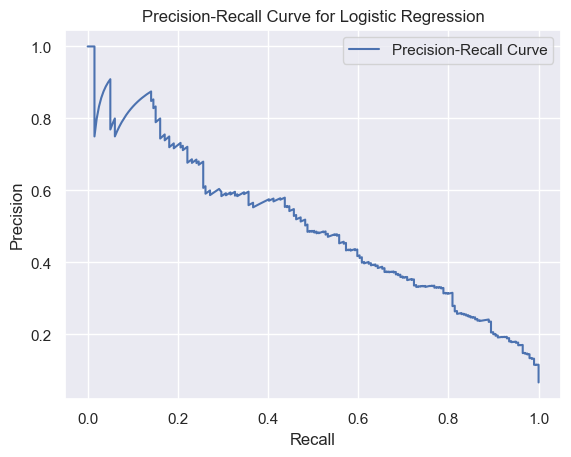

In [34]:
# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend()
plt.show()

A threshold of 0.3 should for about 90% sensitivity:

Text(110.44999999999997, 0.5, 'predicted label')

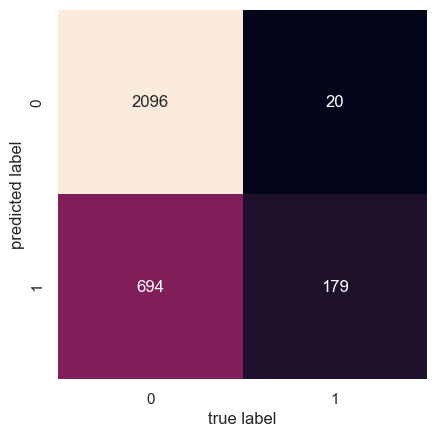

In [43]:
# confusion matrix

# Choose a specific threshold
threshold = 0.3

# Convert probabilities to binary predictions based on the chosen threshold
y_pred = (y_probs >= threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [44]:
# get evaluation
print(metrics.classification_report(y_true=y_test, y_pred=y_probs>0.3))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      2790
           1       0.21      0.90      0.33       199

    accuracy                           0.76      2989
   macro avg       0.60      0.83      0.59      2989
weighted avg       0.94      0.76      0.82      2989



# 6. Predictions on full data

In [40]:
x_unlabelled

array([[-0.02729948,  0.02167973,  0.35824174, ..., -0.06960829,
        -0.00845382,  0.02607262],
       [-0.03080398,  0.00588637,  0.42432806, ..., -0.02386729,
         0.01668894,  0.04827082],
       [-0.02684368,  0.02521074,  0.36128402, ..., -0.08851033,
         0.01537016, -0.02189901],
       ...,
       [ 0.02191888,  0.02748494,  0.39411756, ..., -0.017831  ,
         0.00223454, -0.0055392 ],
       [ 0.00107818,  0.01312841,  0.40042478, ..., -0.11792309,
         0.04319954, -0.03831099],
       [-0.00448724, -0.00716751,  0.30642202, ..., -0.01603545,
        -0.0033478 ,  0.02294911]])

In [63]:
# Predict with Logistic Regression
FT300_logreg_probas  = log_model .predict_proba(x_unlabelled)[:, 1]
FT300_logreg_probas

array([0.92089139, 0.99701031, 0.20976949, ..., 0.11564369, 0.1303273 ,
       0.122113  ], shape=(48148,))

In [64]:
# save the probabilities
np.savetxt("FT300_logreg_probas_2025", FT300_logreg_probas, delimiter=",")

In [ ]:
# add probabilities to dataframe
unemployment_unlabelled['logreg_proba'] = FT300_logreg_probas

In [71]:
# save the dataframe
unemployment_unlabelled.to_csv('unemployment_unlabelled_20250206.csv', index=False)